In [ ]:
#%pip install koreanize_matplotlib


  Using cached koreanize_matplotlib-0.1.1-py3-none-any.whl.metadata (992 bytes)
Using cached koreanize_matplotlib-0.1.1-py3-none-any.whl (7.9 MB)


In [1]:
import torch
import torch.nn as nn 
from torchvision import models, datasets, transforms
from torchvision.models import VGG19_BN_Weights
from torchvision.models import ResNet50_Weights
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import koreanize_matplotlib
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import cv2
import os
import sys
sys.path.append(r'C:\WorkSpace\KDT\MyModule')
from DLModule import *


In [2]:
# 이미지 전처리(transform) 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 정규화 값
])


In [3]:
# 이미지 증강하기

# 원본 이미지 경로
ROOT_PATH = r'C:\WorkSpace\LocalData\pj_14_final\data_a'

# # 증강된 이미지 저장 경로
# SAVE_PATH_A = r'D:\yunho\pj_14_final\data_a'

# ImageFolder 사용
DS = datasets.ImageFolder(root=ROOT_PATH, transform=transform)

originDS = datasets.ImageFolder(root=ROOT_PATH)

# for i in range(len(originDS)):
#     for j in [0, 90, 180, 270]:
#         class_name = DS.classes[DS[i][1]]
#         FILE_PATH = os.path.join(SAVE_PATH_A, class_name, f'img_index{i}_{j}.jpg')
#         FILE_PATH2 = os.path.join(SAVE_PATH_A, class_name, f'flip_img_index{i}_{j}.jpg')
#         rotate_img = originDS[i][0].rotate(j, expand=True)
#         flipped_img = rotate_img.transpose(Image.FLIP_LEFT_RIGHT)
#         rotate_img.save(FILE_PATH)
#         flipped_img.save(FILE_PATH2)

# 데이터 증강 후에 반복문 주석처리하고 ROOT_PATH를 증강한 이미지 저장된 위치로 변경 => 데이터 갯수 확인 후 학습 시작


In [4]:
# DataLoader
DL = DataLoader(DS, batch_size = 32, shuffle=True)

print(f'데이터 클래스 : {DS.classes}\n데이터 개수 : {len(DL.dataset)}개')


데이터 클래스 : ['fire', 'nofire', 'smoke', 'smokefire']
데이터 개수 : 41656개


In [5]:
file_path = [i[0] for i in DS.imgs]
labels = [i[1] for i in DS.imgs]


In [6]:
train_path, test_path, train_labels, test_labels = train_test_split(file_path, labels, stratify=labels,
                                                                    random_state = 42, train_size = 0.8)
train_path, valid_path, train_labels, valid_labels = train_test_split(train_path, train_labels,
                                                                      stratify=train_labels,
                                                                      random_state = 42, train_size = 0.8)


In [7]:
class ImagePathDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        super().__init__()
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform != None:
            image = self.transform(image)

        # 레이블 불러오기
        label = self.labels[idx]

        return image, label


In [8]:
trainDS = ImagePathDataset(train_path, train_labels, transform=transform)
validDS = ImagePathDataset(valid_path, valid_labels, transform=transform)
testDS = ImagePathDataset(test_path, test_labels, transform=transform)

trainDL = DataLoader(trainDS, batch_size = 32)
validDL = DataLoader(validDS, batch_size = 32)
testDL = DataLoader(testDS, batch_size = 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


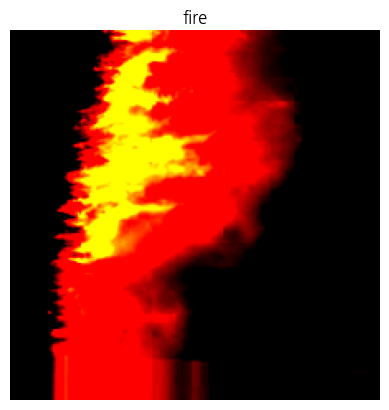

In [9]:
name_dict = {0 : 'fire', 1 : 'nofire', 2: 'smoke' , 3 : 'smokefire'}

INDEX = 15

a = DL.dataset[INDEX][0].permute(1,2,0)
plt.axis('off')
plt.title(name_dict[DL.dataset[INDEX][1]])
plt.imshow(a)
plt.show()


In [16]:
# GPU 사용 가능 여부 확인 
if torch.cuda.is_available():
    print('GPU')
    device = torch.device("cuda")
else:
    print('CPU')
    device = torch.device("cpu")


CPU


> > > 전이학습 모델 - Resnet50


In [17]:
# 전이학습 모델 ResNet (weight 사용)
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.fc.parameters():
    param.requires_grad = True


In [18]:
# 마지막 레이어 (full connected layer) 교체
num_features = model.fc.in_features # 2048
model.fc = nn.Linear(num_features, 4)

# 옵티마이저를 모델 파라미터에 대해 초기화
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [19]:
trainDL.dataset[0][0].shape


torch.Size([3, 224, 224])

In [17]:
EPOCH = 100
SAVE_PATH = r'D:\yunho\pj_14_final\resnet_model'

result=training(trainDL, validDL, model,
                 model_type = 'multiclass', optimizer = optimizer,
                 epoch = EPOCH, endurance_cnt = 5, view_epoch = 1,
                 num_classes = 4, SAVE_PATH = SAVE_PATH)


[EPOCH] : [1] 모델을 저장합니다.
[Loss : 1/100] Train : 0.4473, Test : 0.3352
[Score  : 1/100] Train : 0.8323, Test : 0.8726
[EPOCH] : [2] 모델을 저장합니다.
[Loss : 2/100] Train : 0.2777, Test : 0.3086
[Score  : 2/100] Train : 0.8957, Test : 0.8798
[EPOCH] : [3] 모델을 저장합니다.
[Loss : 3/100] Train : 0.2438, Test : 0.2980
[Score  : 3/100] Train : 0.9076, Test : 0.8826
[EPOCH] : [4] 모델을 저장합니다.
[Loss : 4/100] Train : 0.2237, Test : 0.2921
[Score  : 4/100] Train : 0.9155, Test : 0.8856
[EPOCH] : [5] 모델을 저장합니다.
[Loss : 5/100] Train : 0.2088, Test : 0.2878
[Score  : 5/100] Train : 0.9217, Test : 0.8862
[EPOCH] : [6] 모델을 저장합니다.
[Loss : 6/100] Train : 0.1968, Test : 0.2840
[Score  : 6/100] Train : 0.9261, Test : 0.8882
[EPOCH] : [7] 모델을 저장합니다.
[Loss : 7/100] Train : 0.1868, Test : 0.2806
[Score  : 7/100] Train : 0.9302, Test : 0.8910
[EPOCH] : [8] 모델을 저장합니다.
[Loss : 8/100] Train : 0.1781, Test : 0.2775
[Score  : 8/100] Train : 0.9336, Test : 0.8949
[EPOCH] : [9] 모델을 저장합니다.
[Loss : 9/100] Train : 0.1706, Test : 0

<function matplotlib.pyplot.show(close=None, block=None)>

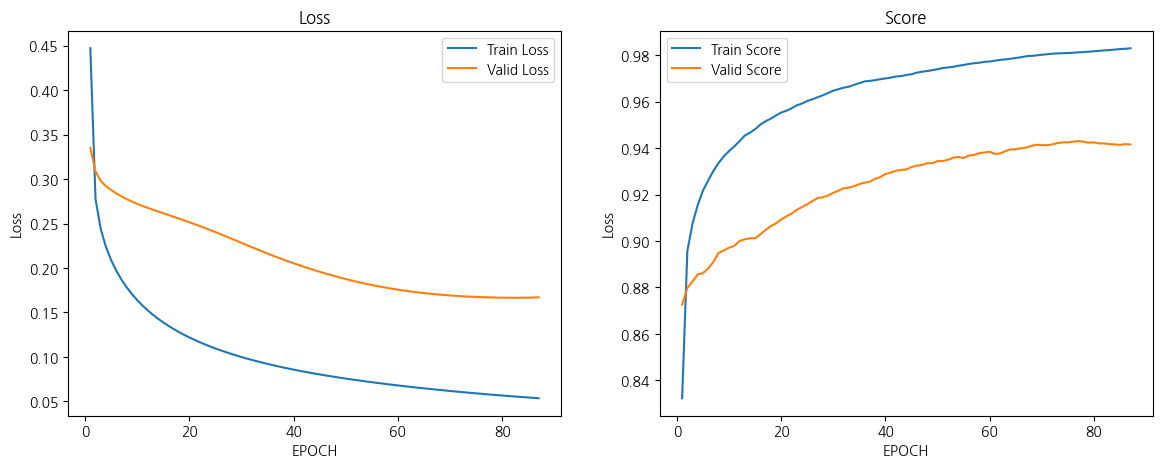

In [18]:
DrawPlot(result)
plt.show


In [20]:
MODEL_PATH=r'C:\WorkSpace\LocalData\pj_14_final\res_model\best_model_epoch_82.pth'

In [21]:
best_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)

best_model.fc = nn.Linear(best_model.fc.in_features, 4)

best_model.load_state_dict(torch.load(MODEL_PATH, weights_only=True, map_location=torch.device('cpu')))


<All keys matched successfully>

In [22]:
input_data = []
target_data = []
for i, j in validDL:
    input_data.append(i)
    target_data.append(j)
    break


In [23]:
input_data[0].shape


torch.Size([32, 3, 224, 224])

In [24]:
pred_value = torch.argmax(best_model(input_data[0]), dim=1)
pred_value


tensor([1, 0, 0, 2, 3, 0, 2, 3, 2, 2, 1, 3, 3, 2, 3, 2, 1, 1, 3, 3, 0, 2, 0, 3,
        1, 0, 3, 2, 2, 1, 0, 3])

In [25]:
{i : DS.classes[i] for i in range(len(DS.classes))}


{0: 'fire', 1: 'nofire', 2: 'smoke', 3: 'smokefire'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


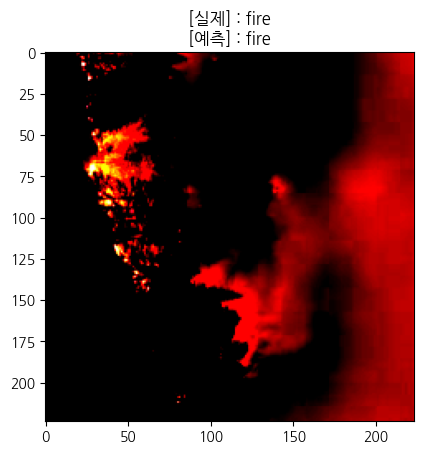

In [27]:
INDEX = 25 # 배치 사이즈 범위 내의 값

name_dict = {i : DS.classes[i] for i in range(len(DS.classes))}
pred_name = name_dict[pred_value[INDEX].item()]
real_name = name_dict[target_data[0][INDEX].item()]
plt.imshow(input_data[0][INDEX].permute(1,2,0))
plt.title(f'[실제] : {real_name}\n[예측] : {pred_name}')
plt.show()


In [ ]:
test_target=[i[0] for i in testDL.dataset]
test_label=[i[1] for i in testDL.dataset]
